# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout


In [2]:
train_folder = "train_kaggle/"
test_folder = "test_kaggle/"

In [3]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

In [14]:
os.listdir("train_kaggle")

['chili-dog_7564.jpg',
 'chili-dog_7565.jpg',
 'chili-dog_7566.jpg',
 'chili-dog_7567.jpg',
 'chili-dog_7570.jpg',
 'chili-dog_7571.jpg',
 'chili-dog_7572.jpg',
 'chili-dog_7573.jpg',
 'chili-dog_7575.jpg',
 'chili-dog_7576.jpg',
 'chili-dog_7577.jpg',
 'chili-dog_7578.jpg',
 'chili-dog_7579.jpg',
 'chili-dog_7581.jpg',
 'chili-dog_7582.jpg',
 'chili-dog_7585.jpg',
 'chili-dog_7586.jpg',
 'chili-dog_7587.jpg',
 'chili-dog_7588.jpg',
 'chili-dog_7590.jpg',
 'chili-dog_7593.jpg',
 'chili-dog_7594.jpg',
 'chili-dog_7600.jpg',
 'chili-dog_7603.jpg',
 'chili-dog_7604.jpg',
 'chili-dog_7610.jpg',
 'chili-dog_7612.jpg',
 'chili-dog_7617.jpg',
 'chili-dog_7620.jpg',
 'chili-dog_7624.jpg',
 'chili-dog_7625.jpg',
 'chili-dog_7626.jpg',
 'chili-dog_7627.jpg',
 'chili-dog_7630.jpg',
 'chili-dog_7631.jpg',
 'chili-dog_7632.jpg',
 'chili-dog_7636.jpg',
 'chili-dog_7638.jpg',
 'chili-dog_7639.jpg',
 'chili-dog_7642.jpg',
 'chili-dog_7643.jpg',
 'chili-dog_7647.jpg',
 'chili-dog_7651.jpg',
 'chili-dog

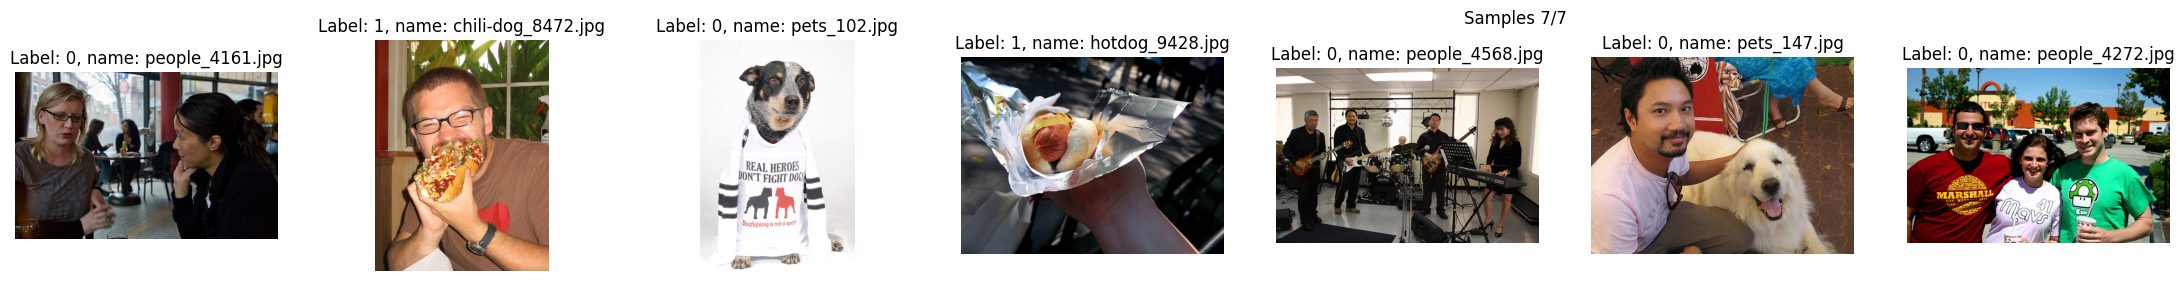

In [4]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder_name = folder
        self.data = os.listdir(folder)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        hot_dog_words = ['frankfurter', 'chili-dog', 'hotdog']
        img = Image.open(os.path.join(self.folder_name, self.data[index]))
        img_id = self.data[index]
        if any(word in img_id for word in hot_dog_words):
            y = 1
        else:
            y = 0
        if self.transform:
            img = self.transform(img)
        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count * 4, 3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, img_id = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title(f"Label: {y}, name: {img_id}")
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

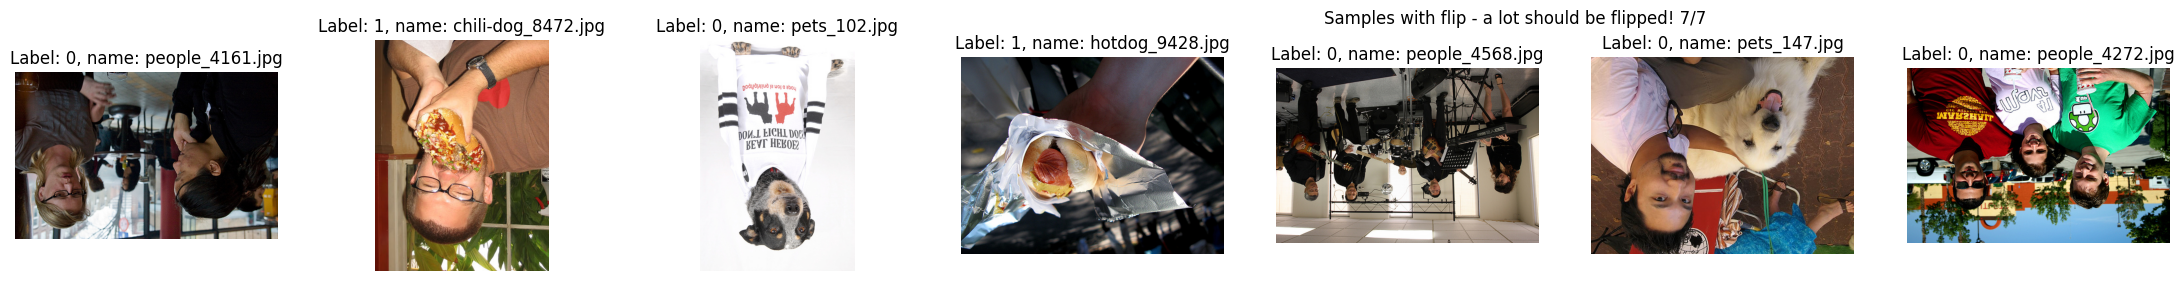

In [5]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [6]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [7]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [9]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    i = 1
    for epoch in range(num_epochs):
        print(f"Epoch: {i}")
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        i += 1
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # Don't forget to move the data to device before running it through the model!
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct, num_samples = 0, 0
    with torch.no_grad():
        for (X, y, _) in loader:
            x_gpu = X.to(device)
            y_gpu = y.to(device)
            pred = model(x_gpu)
            correct += (pred.argmax(1) == y_gpu).type(torch.float).sum().item()
            num_samples += y_gpu.shape[0]
    return correct / num_samples

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

In [9]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)

    return { int(k): v[-1] for k, v in classes.items()}

imagenet_classes = load_imagenet_classes()
imagenet_classes

{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house_finch',
 13: 'junco',
 14: 'indigo_bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water_ouzel',
 21: 'kite',
 22: 'bald_eagle',
 23: 'vulture',
 24: 'great_grey_owl',
 25: 'European_fire_salamander',
 26: 'common_newt',
 27: 'eft',
 28: 'spotted_salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree_frog',
 32: 'tailed_frog',
 33: 'loggerhead',
 34: 'leatherback_turtle',
 35: 'mud_turtle',
 36: 'terrapin',
 37: 'box_turtle',
 38: 'banded_gecko',
 39: 'common_iguana',
 40: 'American_chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled_lizard',
 44: 'alligator_lizard',
 45: 'Gila_monster',
 46: 'green_lizard',
 47: 'African_chameleon',
 48: 'Komodo_dragon',
 49: 'African_crocodile',
 50: 'American_alligator',
 51: 'triceratops',
 

D:\Programms\PyCharm 2022.3.1\saves\edu_project\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Programms\PyCharm 2022.3.1\saves\edu_project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


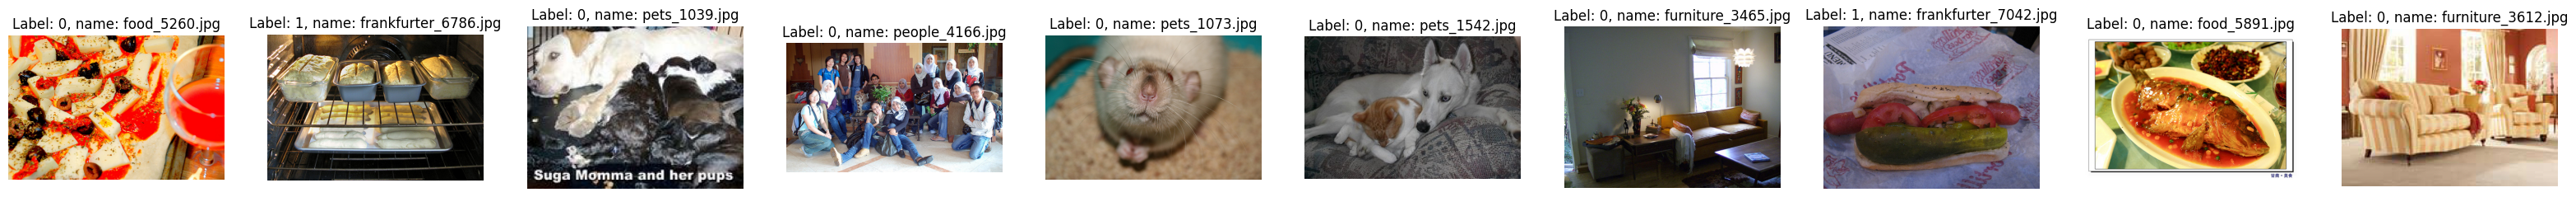

In [10]:
model = models.resnet18(pretrained=True)

indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)
visualize_samples(orig_dataset, indices)

In [12]:
for id in indices:
    # Превращаем отдельную картинку в батч (добавляем на 0 измерение значение 0)
    img, label = train_dataset[id][0].unsqueeze(dim=0), train_dataset[id][1]
    model.eval()
    pred = model(img)
    pred_class = imagenet_classes[int(torch.argmax(pred))]
    print(f"Label: {label}, Predicted class: {pred_class}")

Label: 0, Predicted class: pizza
Label: 1, Predicted class: French_loaf
Label: 0, Predicted class: clumber
Label: 0, Predicted class: pelican
Label: 0, Predicted class: hamster
Label: 0, Predicted class: Siberian_husky
Label: 0, Predicted class: window_shade
Label: 1, Predicted class: hotdog
Label: 0, Predicted class: crayfish
Label: 0, Predicted class: four-poster


In [71]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [14]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
for param in model.parameters():
    param.requires_grad = False

output_in_features = model.fc.in_features
model.fc = nn.Linear(output_in_features, 2)
model.to(device)
parameters = model.fc.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 0.390266, Train accuracy: 0.814553, Val accuracy: 0.922826
Average loss: 0.204734, Train accuracy: 0.923160, Val accuracy: 0.934783
Average loss: 0.182242, Train accuracy: 0.931849, Val accuracy: 0.942391
Average loss: 0.164669, Train accuracy: 0.940538, Val accuracy: 0.942391
Average loss: 0.158062, Train accuracy: 0.941081, Val accuracy: 0.943478
Average loss: 0.154932, Train accuracy: 0.943253, Val accuracy: 0.942391
Average loss: 0.143746, Train accuracy: 0.946511, Val accuracy: 0.945652
Average loss: 0.144522, Train accuracy: 0.945425, Val accuracy: 0.947826
Average loss: 0.142391, Train accuracy: 0.947054, Val accuracy: 0.947826
Average loss: 0.138204, Train accuracy: 0.949769, Val accuracy: 0.946739


# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последний слой на новый и обучать всю модель целиком.

In [19]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
output_in_features = model.fc.in_features
model.fc = nn.Linear(output_in_features, 2)
model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.309269, Train accuracy: 0.852837, Val accuracy: 0.944565
Average loss: 0.141405, Train accuracy: 0.949498, Val accuracy: 0.953261
Average loss: 0.096372, Train accuracy: 0.969047, Val accuracy: 0.953261
Average loss: 0.069971, Train accuracy: 0.979093, Val accuracy: 0.950000
Average loss: 0.049524, Train accuracy: 0.989411, Val accuracy: 0.946739


# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [44]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
# Train new layer with learning speed 0.001 and old layers with 0.0001
output_in_features = model.fc.in_features
model.fc = nn.Linear(output_in_features, 2)
model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD([
    {"params" : [param for name, param in model.named_parameters() if "fc" not in name], "lr": 0.0001, "momentum": 0.9},
    {"params" : model.fc.parameters(), "lr" : 0.001, "momentum": 0.9}
])
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 0.350855, Train accuracy: 0.846049, Val accuracy: 0.913043
Average loss: 0.197570, Train accuracy: 0.925333, Val accuracy: 0.926087
Average loss: 0.168759, Train accuracy: 0.936465, Val accuracy: 0.941304
Average loss: 0.146151, Train accuracy: 0.946511, Val accuracy: 0.939130
Average loss: 0.133238, Train accuracy: 0.948955, Val accuracy: 0.943478
Average loss: 0.123179, Train accuracy: 0.956557, Val accuracy: 0.945652
Average loss: 0.121157, Train accuracy: 0.956557, Val accuracy: 0.947826
Average loss: 0.109933, Train accuracy: 0.956557, Val accuracy: 0.947826
Average loss: 0.102478, Train accuracy: 0.964703, Val accuracy: 0.944565
Average loss: 0.093150, Train accuracy: 0.967418, Val accuracy: 0.945652


# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [19]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    predictions = []
    ground_truth = []
    subset_sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler)

    for (x, y, _) in loader:
        x_gpu, y_gpu = x.to(device), y.to(device)
        pred = torch.argmax(model(x_gpu), 1)
        predictions.extend(pred.tolist())
        ground_truth.extend(y_gpu.tolist())

    return predictions, ground_truth

predictions, gt = evaluate_model(model, train_dataset, val_indices)

In [51]:
len(predictions)

920

И теперь можно визуализировать false positives и false negatives.

In [12]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = [val for i, val in enumerate(val_indices) if predictions[i] != gt[i] and predictions[i] == 1]
visualize_samples(orig_dataset, false_positive_indices, "False positives", 8)

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_indices = [val for i, val in enumerate(val_indices) if predictions[i] != gt[i] and predictions[i] == 0]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives", 8)

NameError: name 'predictions' is not defined

In [13]:
def binary_classification_metrics(prediction, ground_truth):
    precision = 0
    recall = 0
    accuracy = 0
    f1 = 0

    num_samples = len(prediction)
    TP = sum(prediction[i] == ground_truth[i] == 1 for i in range(num_samples))
    FN = sum(prediction[i] == 0 and ground_truth[i] == 1 for i in range(num_samples))
    FP = sum(prediction[i] == 1 and ground_truth[i] == 0 for i in range(num_samples))

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    accuracy = np.sum(prediction == ground_truth) / num_samples
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0.0

    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

NameError: name 'predictions' is not defined

In [20]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def binary_classification_metrics_sklearn(prediction, ground_truth):
    precision = precision_score(ground_truth, prediction)
    recall = recall_score(ground_truth, prediction)
    accuracy = accuracy_score(ground_truth, prediction)
    f1 = f1_score(ground_truth, prediction)

    return precision, recall, f1, accuracy

precision, recall, f1, accuracy = binary_classification_metrics_sklearn(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f A: %4.3f" % (f1, precision, recall, accuracy))

F1: 0.931, P: 0.911, R: 0.952 A: 0.952


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [59]:
tfs_train = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, saturation=0.2, contrast=0.2),
        transforms.RandomHorizontalFlip(0.4),
        transforms.RandomRotation(20),
        transforms.RandomPerspective(p=0.10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

In [60]:
data_train_aug = HotdogOrNotDataset(train_folder, transform=tfs_train)
train_loader_aug = torch.utils.data.DataLoader(data_train_aug, batch_size=batch_size,
                                           sampler=train_sampler)

In [11]:
import torch.nn as nn

In [62]:
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")

output_in_features = model.fc.in_features
model.fc = nn.Linear(output_in_features, 2)
model.to(device)

optimizer = torch.optim.SGD([
    {"params" : [param for name, param in model.named_parameters() if "fc" not in name], "lr": 0.0001, "weight_decay" : 1e-3, "momentum" : 0.9},
    {"params" : model.fc.parameters(), "lr" : 0.001, "weight_decay" : 1e-2, "momentum" : 0.9}
])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
loss = nn.CrossEntropyLoss()
# Возможно можно сделать 30 эпох
loss_history, train_history, val_history = train_model(model, train_loader_aug, val_loader, loss, optimizer, 25)

Epoch: 1
Average loss: 0.381203, Train accuracy: 0.831116, Val accuracy: 0.901087
Epoch: 2
Average loss: 0.225397, Train accuracy: 0.914200, Val accuracy: 0.914130
Epoch: 3
Average loss: 0.195820, Train accuracy: 0.927505, Val accuracy: 0.930435
Epoch: 4
Average loss: 0.182998, Train accuracy: 0.927233, Val accuracy: 0.936957
Epoch: 5
Average loss: 0.178837, Train accuracy: 0.932121, Val accuracy: 0.935870
Epoch: 6
Average loss: 0.166489, Train accuracy: 0.936193, Val accuracy: 0.938043
Epoch: 7
Average loss: 0.162204, Train accuracy: 0.939723, Val accuracy: 0.941304
Epoch: 8
Average loss: 0.156505, Train accuracy: 0.940809, Val accuracy: 0.942391
Epoch: 9
Average loss: 0.157032, Train accuracy: 0.941895, Val accuracy: 0.938043
Epoch: 10
Average loss: 0.155850, Train accuracy: 0.938908, Val accuracy: 0.943478
Epoch: 11
Average loss: 0.145113, Train accuracy: 0.947326, Val accuracy: 0.944565
Epoch: 12
Average loss: 0.140010, Train accuracy: 0.943524, Val accuracy: 0.943478
Epoch: 13
Ave

In [64]:
torch.save(model.state_dict(), "model_weights_SGD_best.pth")

In [12]:
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")

output_in_features = model.fc.in_features
model.fc = nn.Linear(output_in_features, 2)
model.to(device)

model.load_state_dict(torch.load("model_weights_SGD_best.pth", weights_only=True))

<All keys matched successfully>

In [25]:
best_model = model
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, train_dataset, val_indices)
precision, recall, f1, accuracy = binary_classification_metrics_sklearn(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f, A: %4.3f" % (f1, precision, recall, accuracy))

OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.30 GiB is allocated by PyTorch, and 362.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [88]:
print(f"dataset len: {len(dataset)}")
print(f"train len: {len(train_indices)}")
print(f"valid len: {len(val_indices)}")

dataset len: 4603
train len: 3683
valid len: 920


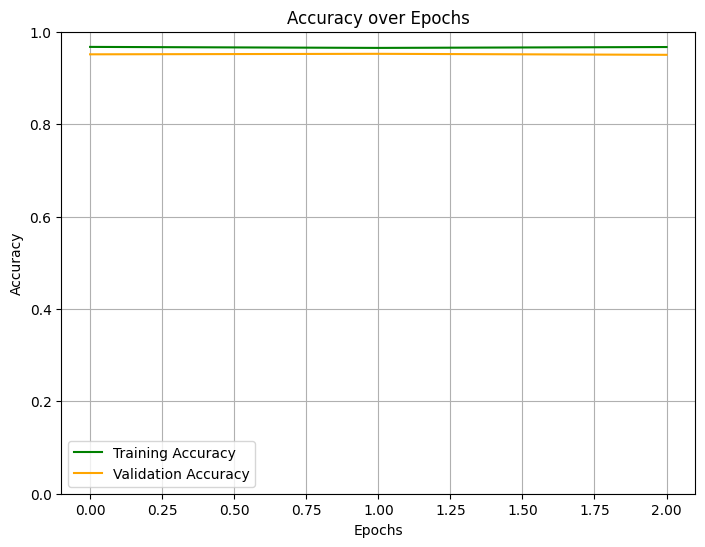

In [76]:
# График точности
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 2)
plt.plot(train_history, label='Training Accuracy', color='green')
plt.plot(val_history, label='Validation Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Установите диапазон Y от 0 до 1 для точности
plt.grid()
plt.legend()

## Визуализируйте ошибки лучшей модели

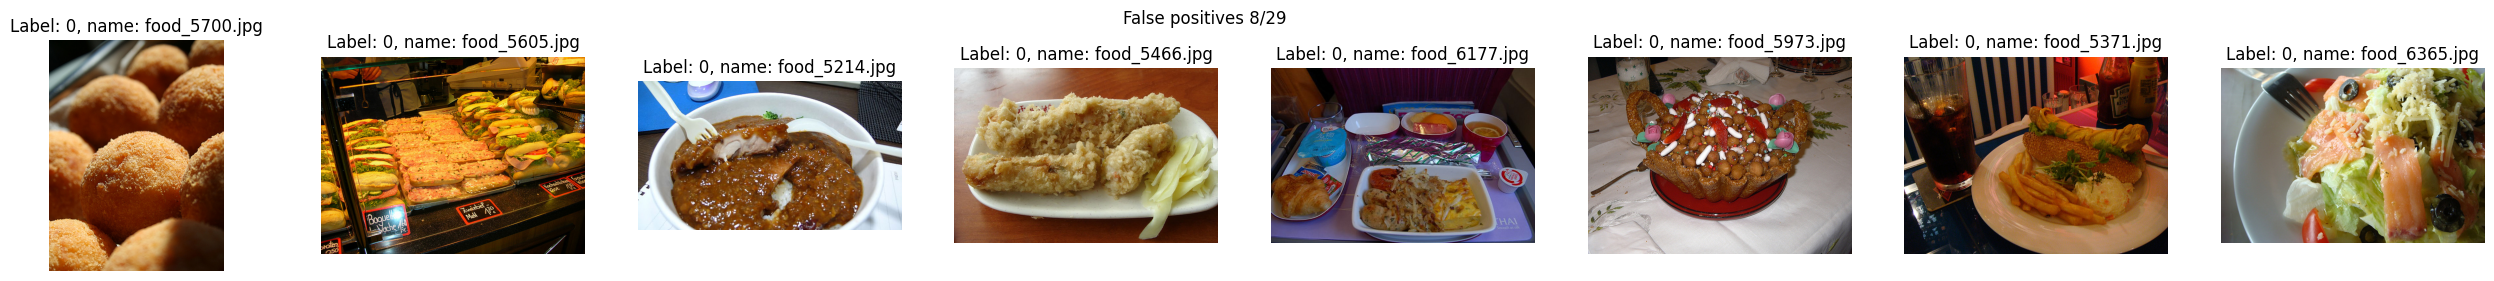

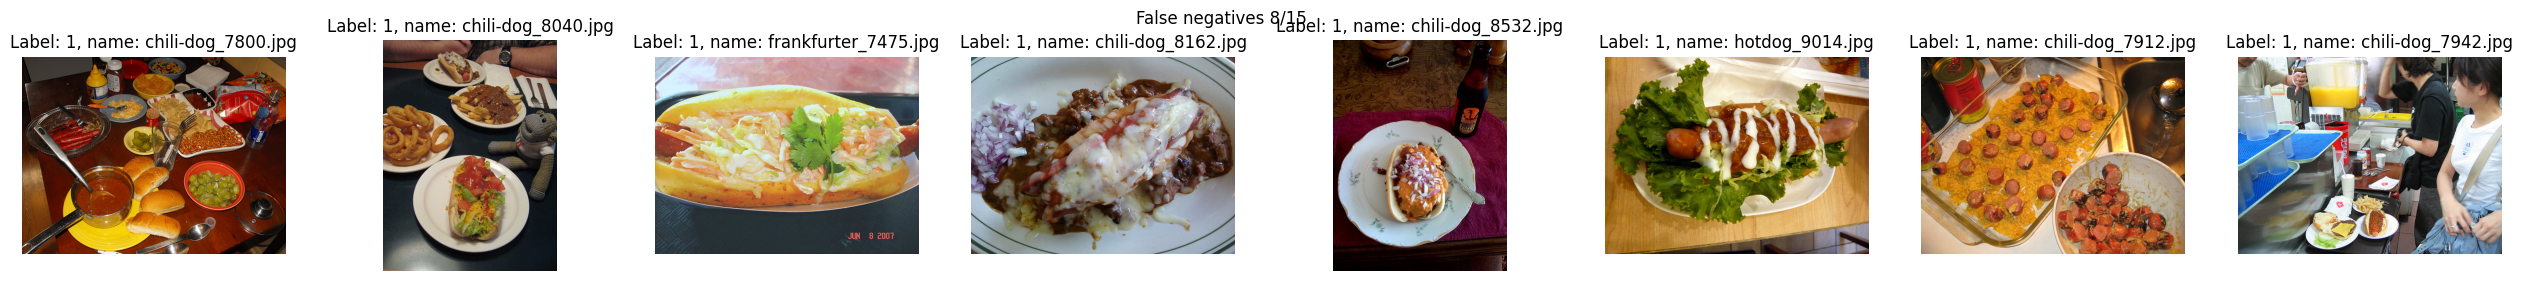

In [79]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = [val for i, val in enumerate(val_indices) if predictions[i] != ground_truth[i] and predictions[i] == 1]
visualize_samples(orig_dataset, false_positive_indices, "False positives", 8)

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_indices = [val for i, val in enumerate(val_indices) if predictions[i] != ground_truth[i] and predictions[i] == 0]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives", 8)

# Необязательное задание с большой звездочкой

Поучавствуйте в Kaggle In-Class Hot Dog Recognition Challenge!  
Это соревнование сделано специально для курса и в нем учавствуют только те, кто проходит курс.

В нем участники соревнуются в качестве натренированных моделей, загружая на сайт предсказания своих моделей на тестовой выборке. Разметка тестовой выборке участникам недоступна.
Более подробно о правилах соревнования ниже.

Те, кто проходят курс лично, за высокое место в соревновании получат дополнительные баллы.

Здесь уже можно использовать и другие базовые архитектуры кроме `resnet18`, и ансамбли, и другие трюки тренировки моделей.

Вот ссылка на соревнование:
https://www.kaggle.com/c/hotdogornot

In [14]:
image_id = []
predictions = []
model.eval()
for x, _, id_img in test_loader:
    x_gpu = x.to(device)
    image_id.extend(id_img)
    pred = torch.argmax(model(x_gpu), 1)
    predictions.extend(pred.tolist())

print(predictions)
print(image_id)

[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

In [15]:
# Так можно создать csv файл, чтобы затем загрузить его на kaggle
# Ожидаемый формат csv-файла:
# image_id,label
# 10000.jpg,1
# 10001.jpg,1
# 10002.jpg,0
# 10003.jpg,1
# 10004.jpg,0

with open('subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id,predictions))

### Небольшое введение в Kaggle для тех, кто не слышал об этой платформе раньше

В основе своей Kaggle - это платформа для проведения соревнований по машинному обучению. Появилась она в 2010 и, пожалуй, стала самой популярной и известной из всех существующих площадок по машинному обучению. Надо сказать, что Kaggle - это не только соревнования, но и сообщество людей, увлеченных машинным обучением. А судя по Википедии, в 2017 году отметка зарегистрированных пользователей перевалила за миллион. Есть там и обучающие материалы, возможность задавать вопросы, делиться кодом и идеями - просто мечта. 

### Как проходят соревнования? 
Обычно участники скачивают данные для обучения моделей (train data), чтобы затем делать предсказания на тестовых данных (test data). Обучающая выборка содержит как сами данные, так и правильные метки (значения зависимой переменной), чтобы можно было обучить модель. Но тестовые данные ответа не содержат - и нашей целью является предсказание меток по имеющимся данным. Файл с ответами для каждого наблюдения из тестовой выборки загружается на Kaggle и оценивается в соответствии с выбранной метрикой соревнования, а результат является публичным и показывается в общей таблице (ее называют еще лидербордом - leaderboard) - чтобы появилось желание посоревноваться и создать еще более сильную модель. В "настоящих" соревнованиях, которые проходят на Kaggle, есть и денежное вознаграждение для тех участников, кто занимает первые места на лидерборде. Например, в [этом](https://www.kaggle.com/c/zillow-prize-1#description) соревновании, человек, занявший первое место, получил около 1 000 000 долларов. 

Тестовые данные делятся случайным образом в некоторой пропорции. И пока соревнование идет, на лидерборде показываются очки и рейтинг участников только по одной части (Public Leaderboard). А вот когда соревнование заканчивается, то рейтинг участников составляется по второй части тестовых данных (Private Leaderboard). И часто можно видеть, как люди занимавшие первые места на публичной части тестовых данных, оказываются далеко не первыми на закрытой части тестовых данных. Зачем это сделано? Есть несколько причин, но, пожалуй, самой фундаментальной является идея недообучения-переобучения. Всегда возможно, что наша модель настроилась на конкретную выборку, но как она поведет себя на тех данных, которые еще не видела? Разбиение тестовых данных на публичную и скрытую части сделано для того, чтобы отобрать модели, которые имеют большую обобщающую способность. Одним из лозунгов участников соревнований стал "Доверяйте своей локальной кросс-валидации" (Trust your CV!). Есть очень большой соблазн оценивать свою модель по публичной части лидерборда, но лучшей стратегией будет выбирать ту модель, которая дает лучшую метрику на кросс-валидации на обучающей выборке. 

В нашем соревновании публичная часть лидерборда составляет 30%, а скрытая 70%. Вы можете делать до двух попыток в день, а оцениваться попытки будут по F1-мере. Удачи и доверяйте своей локальной валидации! В конце соревнования у вас будет возможность выбрать 2 из всех совершенных попыток - лучшая из этих двух и будет засчитана вам на скрытой части тестовых данных.